# Testing box visualization and eval

In [73]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/baldeeb/Code/pytorch-NOCS')

from utils.align import align
from habitat_datagen_util.utils.dataset import HabitatDataset
from habitat_datagen_util.utils.collate_tools import collate_fn
from torch.utils.data import DataLoader
import torch 

dataset  = HabitatDataset('/home/baldeeb/Code/pytorch-NOCS/data/habitat/test')
dataloader = DataLoader(dataset, 
                        batch_size=5, 
                        shuffle=True, 
                        collate_fn=collate_fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
images, targets = next(dataloader.__iter__())
print(f'targets contain: {targets[0].keys()}')

t = targets[0]
# as_list = lambda k, i=0: [t[k] for t in targets]
# masks = as_list('masks')
# coords, depth

_to_ndarray = lambda a : a.numpy() if isinstance(a, torch.Tensor) else a
m, n, d   = (_to_ndarray(t[k]) for k in ['masks', 'nocs', 'depth'])
intrinsic = _to_ndarray(dataset.intrinsic())
transforms, scales, _ = align(m, n, d, intrinsic)

targets contain: dict_keys(['depth', 'masks', 'nocs', 'labels', 'boxes', 'camera_pose', 'intrinsics'])


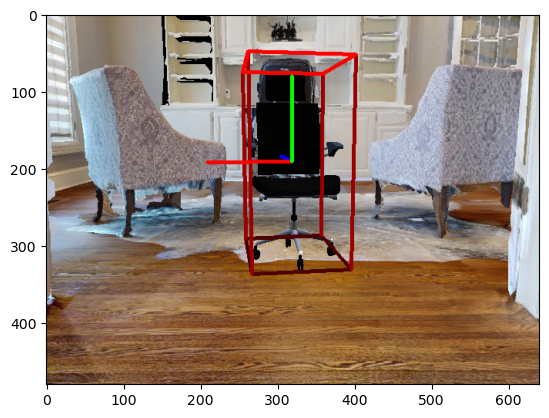

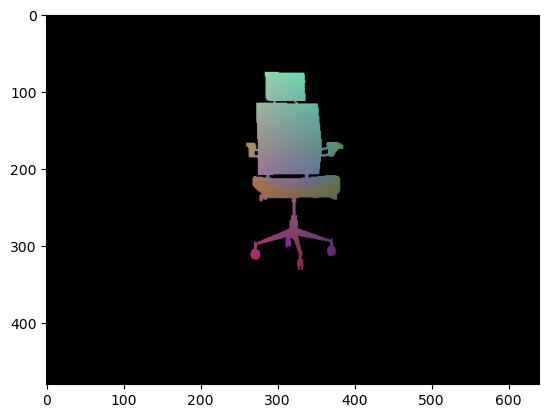

In [75]:
from utils.visualization import draw_3d_boxes
import matplotlib.pyplot as plt

img = draw_3d_boxes(_to_ndarray(images[0].permute(1,2,0)), 
                    _to_ndarray(transforms[0]), 
                    _to_ndarray(scales[0]), 
                    _to_ndarray(intrinsic))
plt.imshow(img)
plt.show()
plt.figure()
plt.imshow(n.transpose((1,2,0)))
plt.show()

# Evaluation 
Check 
 - https://torchmetrics.readthedocs.io/en/v0.11.4/detection/mean_average_precision.html
 - https://pytorch3d.org/docs/iou3d
 - https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/ops/iou_box3d.py
 - https://github.com/hughw19/NOCS_CVPR2019/blob/master/utils.py#L1662 

# Testing the inference wrapper

In [76]:
%load_ext autoreload
%autoreload 2

# Initialize detector
from inference_wrapper import NocsDetector

K = [[591.0125, 0,          322.525], 
    [0,         590.16775,  244.11084], 
    [0,         0,          1]]
# chkpt = './checkpoints/nocs_classification/2023-05-19_14-40-16/run_with_curated_data_4.pth'
chkpt = '/home/baldeeb/Code/pytorch-NOCS/checkpoints/nocs_classification/2023-05-23_20-59-30/old_data_4.pth'
det = NocsDetector(chkpt, K, return_annotated_image=True, 
                    device='cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Get some data
from habitat_datagen_util.utils.dataset import HabitatDataset
from habitat_datagen_util.utils.collate_tools import collate_fn, TransformImagesAndCollate
from torch.utils.data import DataLoader

dataset  = HabitatDataset('../data/habitat/generated/curated_2023_05_19_02_00/test')
dataloader = DataLoader(dataset, 
                        batch_size=1, 
                        shuffle=True, 
                        # collate_fn=collate_fn,)
                        collate_fn=TransformImagesAndCollate())
images, targets = next(dataloader.__iter__())
print(f'targets contain: {targets[0].keys()}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
targets contain: dict_keys(['depth', 'masks', 'nocs', 'labels', 'boxes', 'camera_pose', 'intrinsics'])


In [62]:
images.shape, images.dtype, type(images), images.min(), images.max()

(torch.Size([5, 3, 480, 640]),
 torch.float32,
 torch.Tensor,
 tensor(0.),
 tensor(1.))

In [80]:
import torch
# depth = torch.stack([t['depth'] for t in targets])

depth = d
r = det(images, depth)

dict_keys(['boxes', 'labels', 'scores', 'masks', 'nocs', 'transforms', 'scales', 'annotated_image'])


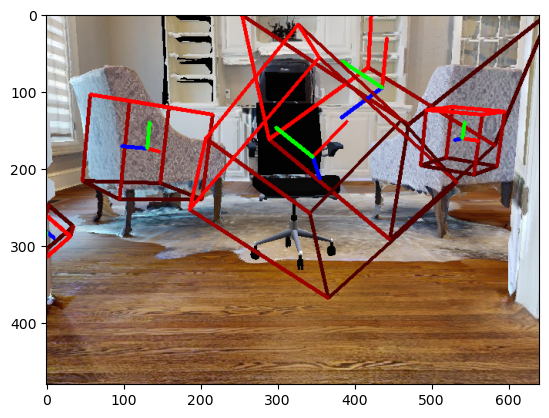

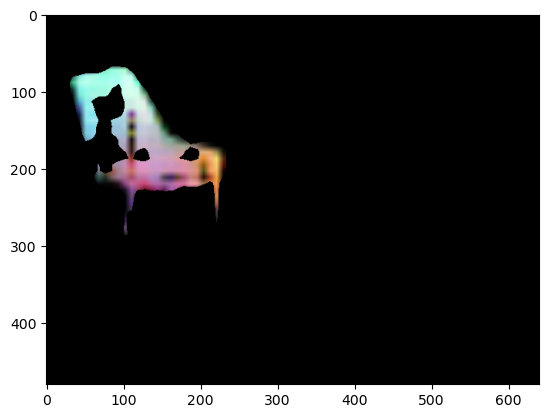

In [81]:
import matplotlib.pyplot as plt
import numpy as np

print(r[0].keys())
plt.figure(); plt.imshow(r[0]['annotated_image'])

m = (r[0]['masks'] > 0.5).clone().detach().cpu().numpy().astype(np.uint8)
n = r[0]['nocs'].clone().detach().cpu().numpy()
n = (n*m)[0].transpose(1,2,0) 
plt.figure(); plt.imshow(n)

# Testing the model with non habitat data

In [79]:
%load_ext autoreload
%autoreload 2

# Initialize detector
from inference_wrapper import NocsDetector
K = [[591.0125, 0,          322.525], 
    [0,         590.16775,  244.11084], 
    [0,         0,          1]]
# # chkpt = './checkpoints/nocs_classification/2023-05-19_14-40-16/run_with_curated_data_4.pth'
# chkpt = '/home/baldeeb/Code/pytorch-NOCS/checkpoints/nocs_classification/2023-05-24_15-49-43/frozen_backbone_4.pth'
# det = NocsDetector(chkpt, K, return_annotated_image=True, perform_alignment=False, 
#                 #    num_classes=2, override_num_classes=True
#                    )

chkpt = '/home/baldeeb/Code/pytorch-NOCS/checkpoints/nocs_classification/2023-06-21_00-37-45/gan_4.pth'
from models.discriminator import DiscriminatorWithOptimizer
nocs_loss = DiscriminatorWithOptimizer(optim_args={'lr': 0.0003, 'betas': [0.5, 0.999]})
det = NocsDetector(chkpt, K, return_annotated_image=True, perform_alignment=True, 
                   num_classes=2, override_num_classes=True,
                   nocs_num_bins=1,
                   nocs_loss_mode='regression',
                   multiheaded_nocs= True,
                   nocs_loss=nocs_loss)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:

# Get some data
import cv2
import numpy as np

# IMG_PATH = '/media/baldeeb/ssd2/Data/SpotStills/9_hand_color_image.jpg'
DEPTH_PATH = '/media/baldeeb/ssd2/Data/SpotStills/9_hand_depth_in_hand_color_frame.jpg'

IMG_PATH = '/home/baldeeb/Downloads/IMG_7329.jpg'
IMG_PATH = '/home/baldeeb/Code/bd_spot_wrapper/data/output/front_left/color/70_frontleft_fisheye_image.png'
# IMG_PATH = '/media/baldeeb/ssd2/Data/SpotStills/11_hand_color_image.jpg'

images = cv2.imread(IMG_PATH)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
images = images.transpose(2,0,1)[None] / 255.0
images = images.astype(np.float32)
depth = cv2.imread(DEPTH_PATH, cv2.IMREAD_ANYDEPTH)
depth = depth[None] / 255.0
depth = depth.astype(np.float32)
r = det(images, depth)
img_i = 0
print(f'Detected {r[img_i ]["scores"].shape[0]} objects in image {img_i}')
# images.shape, images.dtype, images.min(), images.max(), depth.shape, depth.dtype, depth.min(), depth.max()

Detected 4 objects in image 0


found 4 objects


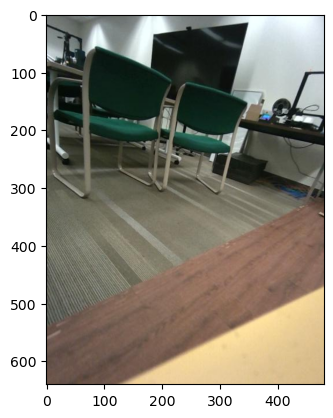

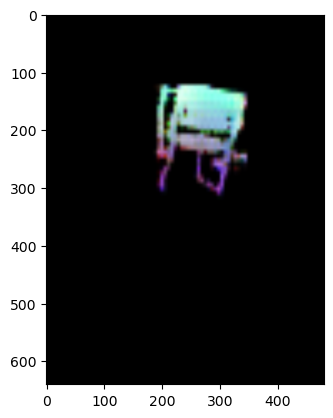

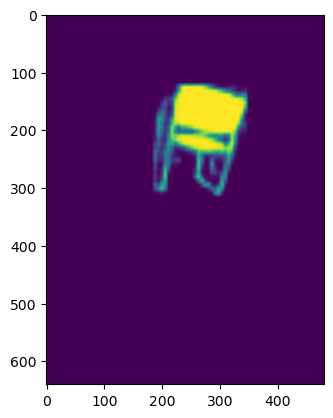

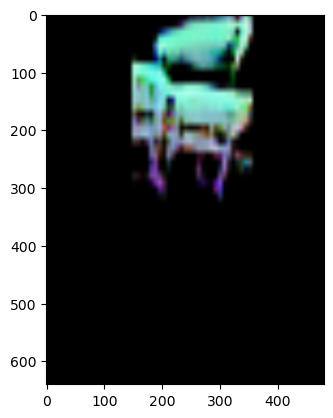

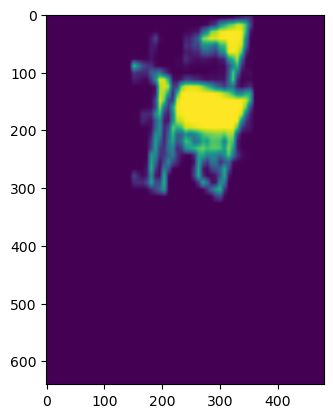

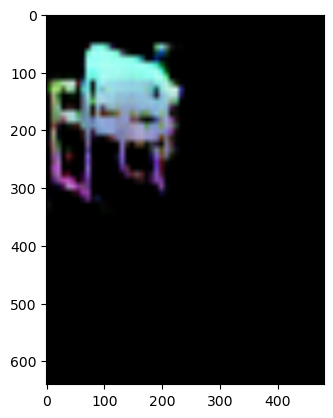

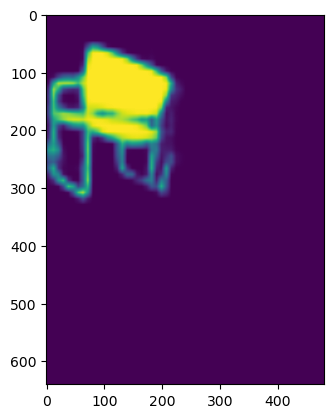

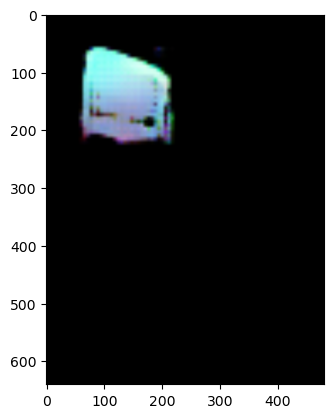

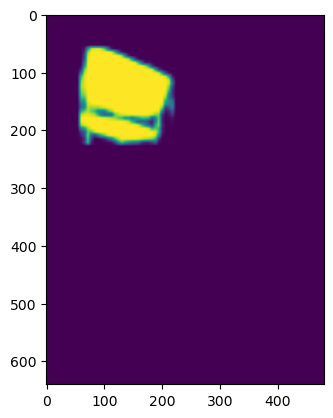

In [17]:
import matplotlib.pyplot as plt
print(f'found {len(r[0]["nocs"])} objects')
obj_i = 1
plt.figure()
plt.imshow(images[0].transpose(1,2,0))
for obj_i in range(len(r[0]['nocs'])):
    plt.figure()
    plt.imshow(r[0]['nocs'][obj_i].clone().detach().cpu().numpy().transpose(1,2,0))
    plt.figure()
    plt.imshow(r[0]['masks'][obj_i].clone().detach().cpu().numpy().transpose(1,2,0))



# plt.figure()
# plt.imshow(images[0].transpose(1,2,0))
# idxs = r[0]['scores'] > 0.5
# accumulated = (r[0]['masks'][idxs] * r[0]['nocs'][idxs]).sum(0)
# plt.figure()
# plt.imshow(accumulated.clone().detach().cpu().numpy().transpose(1,2,0))

In [84]:
%load_ext autoreload
%autoreload 2
import torch
from models.nocs import get_nocs_resnet50_fpn
from utils.load_save import load_nocs
chkpt = './checkpoints/nocs_classification/2023-05-24_15-49-43/frozen_backbone_4.pth'
nocs = load_nocs(chkpt)

nocs.eval()
nocs.cuda()

i = torch.from_numpy(images).to('cuda')
n = nocs(i)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AssertionError: targets should not be none when in training mode